* $\boldsymbol{x} \in \mathbb{R}^D $
* $\boldsymbol{x} \sim \mathcal{N}(0, \frac{1}{D}\boldsymbol{I}) $

\\

* $ \{ (\boldsymbol{x}_\mu, \; y_\mu) \}_{\mu = 1}^P $：データセット

**モデル：**


$f(\boldsymbol{w}, \boldsymbol{x}) = \frac{\alpha}{N} \sum_{i=1}^N \phi(\boldsymbol{w}_i \cdot \boldsymbol{x})$

* $\phi(h) = h + \frac{\epsilon}{2}h^2$

\\

**ターゲット：**

* $ y(\boldsymbol{x}) = \frac{1}{2}(\boldsymbol{\beta}_{\star} \cdot \boldsymbol{x})^2 $

Epoch [100/10000], Train Loss: 0.3956, Test Loss: 0.5138
Epoch [200/10000], Train Loss: 0.3367, Test Loss: 0.5482
Epoch [300/10000], Train Loss: 0.3059, Test Loss: 0.5905
Epoch [400/10000], Train Loss: 0.2891, Test Loss: 0.6347
Epoch [500/10000], Train Loss: 0.2791, Test Loss: 0.6744
Epoch [600/10000], Train Loss: 0.2726, Test Loss: 0.7076
Epoch [700/10000], Train Loss: 0.2679, Test Loss: 0.7356
Epoch [800/10000], Train Loss: 0.2644, Test Loss: 0.7603
Epoch [900/10000], Train Loss: 0.2618, Test Loss: 0.7828
Epoch [1000/10000], Train Loss: 0.2598, Test Loss: 0.8038
Epoch [1100/10000], Train Loss: 0.2583, Test Loss: 0.8235
Epoch [1200/10000], Train Loss: 0.2571, Test Loss: 0.8416
Epoch [1300/10000], Train Loss: 0.2563, Test Loss: 0.8581
Epoch [1400/10000], Train Loss: 0.2557, Test Loss: 0.8727
Epoch [1500/10000], Train Loss: 0.2553, Test Loss: 0.8855
Epoch [1600/10000], Train Loss: 0.2550, Test Loss: 0.8964
Epoch [1700/10000], Train Loss: 0.2547, Test Loss: 0.9055
Epoch [1800/10000], Tra

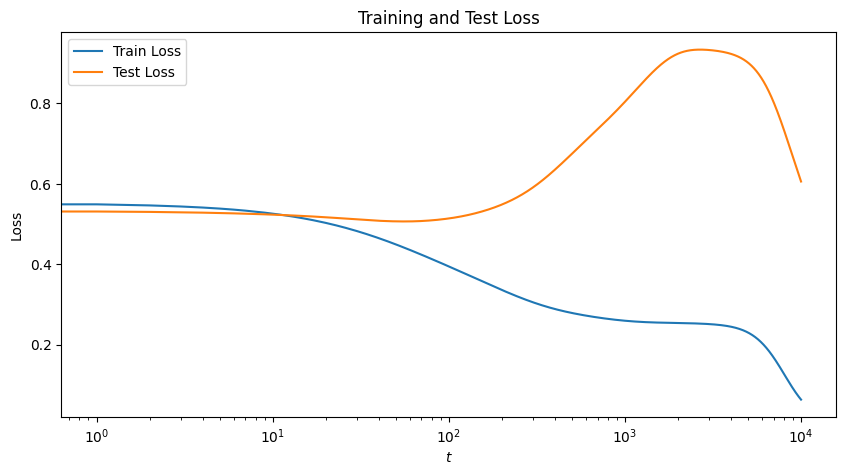

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# パラメータの設定
D = 50        # 入力次元数
N = 100       # 隠れユニットの数
P_train = 100  # 訓練データセットのサイズ
P_test = 100   # テストデータセットのサイズ
epsilon = 2 ** (-5)  # 初期 NTK アラインメントを制御するパラメータ
alpha = 2 ** 5  # 出力スケール/遅延性を制御するパラメータ
eta_0 = 0.1    # 学習率
epochs = 10 ** 4  # 訓練エポック数
optimizer_type = 'Adam'  # 'SGD', 'Adam', 'RMSprop', or 'GD (vanilla)'

# データセットの生成
X_train = torch.normal(0, 1/D**(0.5), size=(P_train, D))
beta_star = torch.randn(D)
y_train = 0.5 * (X_train @ beta_star).pow(2)

X_test = torch.normal(0, 1/D**(0.5), size=(P_test, D))
y_test = 0.5 * (X_test @ beta_star).pow(2)

# ニューラルネットワークの定義
class TwoLayerMLP(nn.Module):
    def __init__(self, D, N, epsilon, alpha):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(D, N, bias=False)
        self.epsilon = epsilon
        self.alpha = alpha

    def forward(self, x):
        h = self.fc1(x)
        return (self.alpha / N) * (h + (self.epsilon / 2) * h**2).sum(dim=1)

# モデル，損失関数の初期化
model = TwoLayerMLP(D, N, epsilon, alpha)
criterion = nn.MSELoss()

# オプティマイザの選択
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'GD':
    optimizer = None
else:
    raise ValueError("Unsupported optimizer type")

# 訓練
train_losses = []
test_losses = []
for epoch in range(epochs):

    model.train()

    if optimizer_type == 'GD':
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= (eta_0 / alpha**2) * param.grad  # 勾配降下法によるパラメータの更新
        model.zero_grad()
    else:
        # 他のオプティマイザの場合
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    # テスト
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# プロット
plt.figure(figsize=(10, 5))
plt.semilogx(train_losses, label='Train Loss')
plt.semilogx(test_losses, label='Test Loss')
plt.xlabel('$t$')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

Epoch [100/10000], Train Accuracy: 0.6000, Test Accuracy: 0.3900
Epoch [200/10000], Train Accuracy: 0.6900, Test Accuracy: 0.4700
Epoch [300/10000], Train Accuracy: 0.6800, Test Accuracy: 0.4500
Epoch [400/10000], Train Accuracy: 0.6900, Test Accuracy: 0.4400
Epoch [500/10000], Train Accuracy: 0.6800, Test Accuracy: 0.4600
Epoch [600/10000], Train Accuracy: 0.6900, Test Accuracy: 0.4600
Epoch [700/10000], Train Accuracy: 0.7000, Test Accuracy: 0.4700
Epoch [800/10000], Train Accuracy: 0.6900, Test Accuracy: 0.4900
Epoch [900/10000], Train Accuracy: 0.7000, Test Accuracy: 0.5000
Epoch [1000/10000], Train Accuracy: 0.7000, Test Accuracy: 0.5000
Epoch [1100/10000], Train Accuracy: 0.7100, Test Accuracy: 0.5000
Epoch [1200/10000], Train Accuracy: 0.7100, Test Accuracy: 0.5000
Epoch [1300/10000], Train Accuracy: 0.7100, Test Accuracy: 0.5000
Epoch [1400/10000], Train Accuracy: 0.7100, Test Accuracy: 0.4900
Epoch [1500/10000], Train Accuracy: 0.7300, Test Accuracy: 0.4700
Epoch [1600/10000],

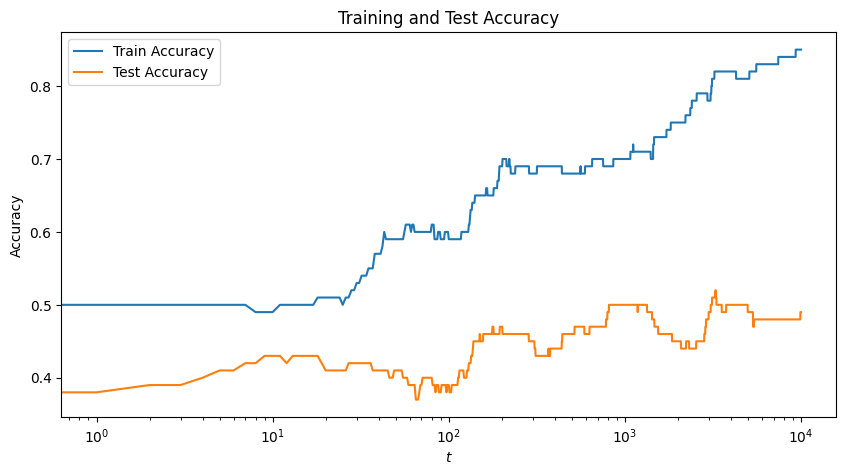

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# パラメータの設定
D = 50        # 入力次元数
N = 100       # 隠れユニットの数
P_train = 100  # 訓練データセットのサイズ
P_test = 100   # テストデータセットのサイズ
epsilon = 2 ** (-5)  # 初期 NTK アラインメントを制御するパラメータ
alpha = 2 ** 5  # 出力スケール/遅延性を制御するパラメータ
eta_0 = 0.1    # 学習率
epochs = 10 ** 4  # 訓練エポック数
optimizer_type = 'Adam'  # 'SGD', 'Adam', 'RMSprop', or 'GD (vanilla)'

# データセットの生成（分類問題用に変更）
X_train = torch.normal(0, 1/D**(0.5), size=(P_train, D))
beta_star = torch.randn(D)
y_train = (0.5 * (X_train @ beta_star).pow(2) > 0.5).float().view(-1, 1)  # 0 または 1 のラベル

X_test = torch.normal(0, 1/D**(0.5), size=(P_test, D))
y_test = (0.5 * (X_test @ beta_star).pow(2) > 0.5).float().view(-1, 1)  # 0 または 1 のラベル

# ニューラルネットワークの定義
class TwoLayerMLP(nn.Module):
    def __init__(self, D, N, epsilon, alpha):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(D, N, bias=False)
        self.fc2 = nn.Linear(N, 1, bias=False)  # 出力層
        self.epsilon = epsilon
        self.alpha = alpha

    def forward(self, x):
        h = self.fc1(x)  # [batch_size, N]
        h = (self.alpha / N) * (h + (self.epsilon / 2) * h**2)  # [batch_size, N]
        h = self.fc2(h)  # [batch_size, 1]
        return h

# モデル，損失関数の初期化
model = TwoLayerMLP(D, N, epsilon, alpha)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits Loss

# オプティマイザの選択
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'GD':
    optimizer = None
else:
    raise ValueError("Unsupported optimizer type")

# 訓練と評価
train_accuracies = []
test_accuracies = []
for epoch in range(epochs):

    model.train()

    if optimizer_type == 'GD':
        outputs = model(X_train)
        outputs = outputs.squeeze()  # [batch_size]
        loss = criterion(outputs, y_train.squeeze())  # [batch_size]
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= (eta_0 / alpha**2) * param.grad
        model.zero_grad()
    else:
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)  # [batch_size, 1]
        loss.backward()
        optimizer.step()

    # 訓練データの精度計算
    with torch.no_grad():
        outputs = model(X_train)
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        train_accuracy = (predictions == y_train).float().mean().item()
        train_accuracies.append(train_accuracy)

        # テストデータの精度計算
        outputs = model(X_test)
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        test_accuracy = (predictions == y_test).float().mean().item()
        test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracies[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')

# 精度のプロット
plt.figure(figsize=(10, 5))
plt.semilogx(train_accuracies, label='Train Accuracy')
plt.semilogx(test_accuracies, label='Test Accuracy')
plt.xlabel('$t$')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()